In [179]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn import datasets
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold
import scipy


In [180]:
digits = datasets.load_digits()
print(digits.images.shape)

(1797, 8, 8)


In [181]:
X_train, X_test, y_train, y_test = train_test_split(digits.images, digits.target, test_size=0.1, shuffle=False)
X_train = X_train.reshape(-1, 64)
X_test  = X_test.reshape(-1, 64)

In [200]:
def accuracy(model, x, y):
    return (model.predict(x) == y).sum() / y.shape[0]
    
def train_test_model(model):
    kfold = KFold(5, shuffle=True)
    val_acc = []
    train_acc = []
    for train_index, test_index in kfold.split(X_train):
        X_train_k, X_test_k = X_train[train_index], X_train[test_index]
        y_train_k, y_test_k = y_train[train_index], y_train[test_index]

        model.fit(X_train_k, y_train_k)
        y_hat = dt.predict(X_test_k)
        val_acc.append(accuracy(model, X_test_k, y_test_k))
        train_acc.append(accuracy(model, X_train_k, y_train_k))
    return sum(train_acc)/len(train_acc), sum(val_acc)/len(val_acc)


## Task 1 
In this section we explore some different hyperparameters with the vanilla Classification Decision Tree. First we explore
how the max_depth variable may affect overfitting. The first graph are the train/val accuracies (measured with k-fold cross validation) of the model for different max_depth settings. We see that fairly quickly that the train accuracy hits 100%. This would typically indicate overfitting as our validation accuracies paltue at an accuracy of 80%. However they do not fall off. This could be for a number of reasons such as our dataset being large enough that perphaps despite it completely fitting the train data it still must capture highly important features which result in the model generalizing very well. The other parameter we play with is the mean_leaf parameter which only allows leafs to be formed when they contain at least mean_leaf examples bucketed into them from the train data. This results in a decrease in the train accuracy. However the val accuarcy doesn't decrease, this indicates that the model had fit the data to a level that didn't result in superior preformance on unseen examples. 

In [201]:
#Testing default preformance
dt = tree.DecisionTreeClassifier()
score = train_test_model(dt)
print(score)

(1.0, 0.8496942246684249)


<BarContainer object of 15 artists>

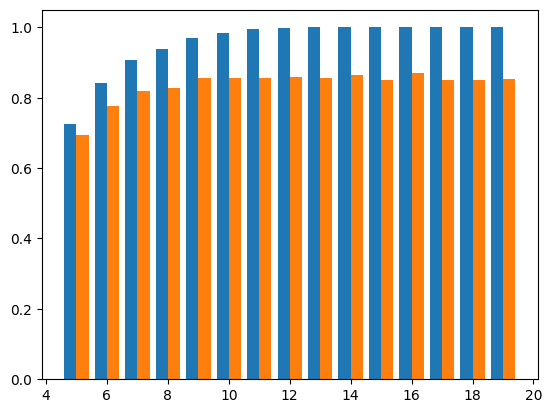

In [202]:
RANGE = (5, 20)
MAX_DEPTH_RANGE = [train_test_model(tree.DecisionTreeClassifier(max_depth=i))
                           for i in range(*RANGE)]
TRAIN = [item[0] for item in MAX_DEPTH_RANGE]
TEST = [item[1] for item in MAX_DEPTH_RANGE]
DEPTHS = np.array([i for i in range(*RANGE)])

plt.bar(DEPTHS - 0.2, TRAIN, 0.4, label = 'Train Acc') 
plt.bar(DEPTHS + 0.2, TEST, 0.4, label = 'Test Acc') 


<BarContainer object of 18 artists>

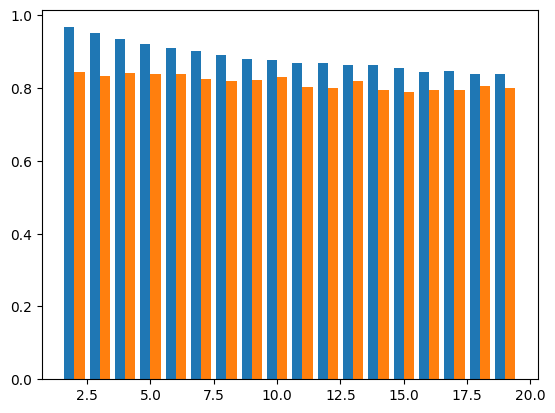

In [203]:
RANGE = (2, 20)
MAX_DEPTH_RANGE = [train_test_model(tree.DecisionTreeClassifier(min_samples_leaf=i))
                           for i in range(*RANGE)]
TRAIN = [item[0] for item in MAX_DEPTH_RANGE]
TEST = [item[1] for item in MAX_DEPTH_RANGE]
DEPTHS = np.array([i for i in range(*RANGE)])

plt.bar(DEPTHS - 0.2, TRAIN, 0.4, label = 'Train Acc') 
plt.bar(DEPTHS + 0.2, TEST, 0.4, label = 'Test Acc') 


## Task 2
I have chose to implement Boostrapping for my bagging example and Gradient Boosint for my Boosting example. Both algorithms yield noticiably higher validation accuracy both by over 10%. With the default decision tree hitting an asymptote at a val accuracy of about 80% the bagging example has an accuracy of 93% and the boosing example hits an accuracy of 96%. Both also do not fully fit the train data as they both have test accuracies < 100. I reference this article for the generalization of gradient boosting to categorical classification from the binary case: https://python-bloggers.com/2023/10/gradient-boosting-multi-class-classification-from-scratch/

In [204]:
def random_subset(x,y, length):
    dset = [(x_i, y_i) for x_i, y_i in zip(x,y)]
    random.shuffle(dset)
    return dset[:length]

In [222]:
class Bootstrapping:
    def __init__(self, max_depth, num_models, subset_length, class_weight=None):
        self.max_depth = max_depth
        self.num_models = num_models
        self.subset_length = subset_length
        self.models = [tree.DecisionTreeClassifier(max_depth=max_depth, class_weight=class_weight) for _ in range(num_models)]
    def fit(self, x,y):
        for model in self.models:
            dset = random_subset(x, y, self.subset_length)
            x_ = [item[0] for item in dset]
            y_ = [item[1] for item in dset]
            model = model.fit(x_, y_)
    def predict(self, x):
        outputs = []
        for model in self.models:
            outputs.append(model.predict(x))
        outputs = np.array(outputs)
        return scipy.stats.mode(outputs)[0]
        
            

In [206]:
bagged = Bootstrapping(12, 20, 250)

In [215]:
train_test_model(bagged)

(0.9709333696721497, 0.9294996751137102)

In [216]:
class GradientBoosingClassifier():
    """
    Gradient Boosing Classifier for a categorical classification
    """
    def __init__(self, max_depth, num_models, class_num, lr):
        self.models = []
        self.max_depth = max_depth
        self.num_models = num_models
        self.class_num = class_num
        self.lr = lr

    def _one_hot_encoding(values, n_classes):
        one_hot = np.zeros((values.shape[0], n_classes))
        one_hot[np.arange(values.shape[0]), values] = 1
        return one_hot

    def _softmax(x):
        """
        x.shape = [n, k] ; n=#examples, k = #classes
        """
        return np.exp(x)/(np.exp(x).sum(axis=1, keepdims=True))

    def _residual(current_predictions, y):
        return y - GradientBoosingClassifier._softmax(current_predictions)
    
    def fit(self, x,y):
        y = GradientBoosingClassifier._one_hot_encoding(y, self.class_num)
        current_predictions = np.zeros(y.shape)
        for n in range(self.num_models):
            k_class_trees = []
            residuals = GradientBoosingClassifier._residual(current_predictions, y)
            #predict the residual for each class
            for k in range(self.class_num):
                dt = tree.DecisionTreeRegressor(max_depth=self.max_depth)
                dt.fit(x, residuals[:, k])
                current_predictions[:, k] += self.lr * dt.predict(x)
                k_class_trees.append(dt)
                
            self.models.append(k_class_trees)
            
    def predict(self, x):
        current_predictions = np.zeros((x.shape[0], self.class_num))
        for model in self.models:
            for k in range(self.class_num):
                current_predictions[:, k] += self.lr * model[k].predict(x)
        return np.argmax(current_predictions, axis=1)
        
        
                
                
        
        

In [218]:
grad_boost = GradientBoosingClassifier(max_depth=4, num_models=8, class_num=10, lr=0.5)
train_test_model(grad_boost)

(0.9856211845736944, 0.967257195275771)

## Task 3
Both ensemble methods clearly demonstrate lower variance models which also end up having significantly more accuracy on the validation set. The val accuracy vs train accuracy split in the gradient boosting example is around 2% and around 5% for bagging. This is far lower than the vanilla decision tree's 20% as shown earlier. The gradient boosing algorithm performs the best out of the three however there still is room for improvement for all three models as none of them had a proper hyper-parameter search applied to them. The overall accuracy of the model serves as a good metric as each class has about the same number of examples in the dataset. In the case of digit recognition we also do not weight the accuracy of one class over another they are all equally important when it comes to the task of digit recognition it would be useless if our model was really good at classifying 7's and not so much for 0's. However if my dataset was medical data and the class 0 and 1 were serious illness's which where false negative could be deadly I would follow different guiding metric such as recall on the first two classes, which gives the precentage of positive examples which we correctly classified. This would also result in training a model with higher weights on those classes. In the example below I attempt to show how recall changes when we add a weight of 100000x the other classes on the first class, when training with bagging. Unfortunately the weigh

<BarContainer object of 10 artists>

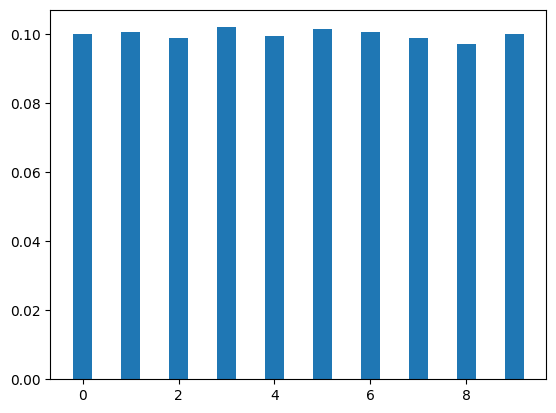

In [219]:
train_class_freq = [(y_train==i).sum()/y_train.shape[0] for i in range(10)]
classes = [i for i in range(10)]
plt.bar(classes, train_class_freq, 0.4, label = 'Train Class Precentages') 

In [226]:
def recall_class0(model, x, y):
    y_hat = model.predict(x)
    true_positive = ((y_hat==0) & (y==0)).sum()
    false_negative = ((y_hat!=0) & (y==0)).sum()
    return true_positive/(true_positive+false_negative)
    
def train_test_model_recall(model):
    kfold = KFold(5, shuffle=True)
    val_acc = []
    train_acc = []
    for train_index, test_index in kfold.split(X_train):
        X_train_k, X_test_k = X_train[train_index], X_train[test_index]
        y_train_k, y_test_k = y_train[train_index], y_train[test_index]

        model.fit(X_train_k, y_train_k)
        y_hat = dt.predict(X_test_k)
        val_acc.append(recall_class0(model, X_test_k, y_test_k))
        train_acc.append(recall_class0(model, X_train_k, y_train_k))
    return sum(train_acc)/len(train_acc), sum(val_acc)/len(val_acc)


In [272]:
weights = {i:1/100 for i in range(10)}
weights[0] = 10000000
bagged_w = Bootstrapping(12, 20, 250, class_weight=weights)
print(train_test_model_recall(bagged_w))
bagged = Bootstrapping(12, 20, 250)
print(train_test_model_recall(bagged))


(0.9923963003352316, 0.9874877810361682)
(0.9984496124031008, 0.9868817204301076)
